In [1]:
# global packages
%matplotlib inline
import tensorflow as tf
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from os import path

/home/berti/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
assert tf.__version__=='1.0.0', ('You should use Tensorflow 1.0.0')

In [3]:
# local packages
import sys
sys.path.append('../')
from src.convolutional import *

In [4]:
# net to import
net_path = '../pretrained/xc_conv5_32c_s4_e40.mat'
# this is defined manually and should reflect the network to import
conv_stride = np.array([2,1,1,1,1])
filtergroup_yn = np.array([0,1,0,1,1], dtype=bool)
bnorm_yn = np.array([1,1,1,1,0], dtype=bool)
relu_yn = np.array([1,1,1,1,0], dtype=bool)
pool_stride = np.array([2,1,0,0,0]) # 0 means no pool
pool_sz = 3
bnorm_adjust = True

assert len(conv_stride) == len(filtergroup_yn) == len(bnorm_yn) == len(relu_yn) == len(pool_stride), ('These arrays of flags should have same length')
assert all(conv_stride) >= True, ('The number of conv layers is assumed to define the depth of the network')
num_layers = len(conv_stride)

In [5]:
# read mat file from path
mat = scipy.io.loadmat(net_path)
## This is for .mat files saved with --v7.3
# import h5py
# net_file = h5py.File(net_path, 'r')
# data = f.get('...') 
net_dot_mat = mat.get('net')

In [6]:
# organize parameters to import
params = net_dot_mat['params']
params = params[0][0]
params_names = params['name'][0]
params_names_list = [params_names[p][0] for p in xrange(params_names.size)]
params_values = params['value'][0]
params_values_list = [params_values[p] for p in xrange(params_values.size)]

In [7]:
# placeholders for search region crop X and exemplar crop Z
X = tf.placeholder(tf.float32)
net_x = X
# net_x = tf.expand_dims(X, 0)
Z = tf.placeholder(tf.float32)
net_z = Z
# net_z = tf.expand_dims(Z, 0)

# find all parameters matching the codename (there should be only one)
def find_params(x, params):
    matching = [s for s in params if x in s]
    assert len(matching)==1, ('Ambiguous param name found')    
    return matching

# loop through the flag arrays and re-construct network, reading parameters of conv and bnorm layers
for i in xrange(num_layers):
    print '> Layer '+str(i+1)
    # conv
    conv_W_name = find_params('conv'+str(i+1)+'f', params_names_list)[0]
    conv_b_name = find_params('conv'+str(i+1)+'b', params_names_list)[0]
    print '\t\tCONV: setting '+conv_W_name+' '+conv_b_name
    print '\t\tCONV: stride '+str(conv_stride[i])+', filter-group '+str(filtergroup_yn[i])
    conv_W = params_values_list[params_names_list.index(conv_W_name)]
    conv_b = params_values_list[params_names_list.index(conv_b_name)]
    # batchnorm
    if bnorm_yn[i]:
        bn_beta_name = find_params('bn'+str(i+1)+'b', params_names_list)[0]
        bn_gamma_name = find_params('bn'+str(i+1)+'m', params_names_list)[0]
        bn_moments_name = find_params('bn'+str(i+1)+'x', params_names_list)[0]
        print '\t\tBNORM: setting '+bn_beta_name+' '+bn_gamma_name+' '+bn_moments_name
        bn_beta = params_values_list[params_names_list.index(bn_beta_name)]
        bn_gamma = params_values_list[params_names_list.index(bn_gamma_name)]
        bn_moments = params_values_list[params_names_list.index(bn_moments_name)]
        bn_moving_mean = bn_moments[:,0]
        bn_moving_variance = bn_moments[:,1]**2 # saved as std in matconvnet
    else:
        bn_beta = bn_gamma = bn_moving_mean = bn_moving_variance = []
    
    # set up conv "block" with bnorm and activation 
    net_x = set_convolutional(net_x, conv_W, np.swapaxes(conv_b,0,1), conv_stride[i], \
                        bn_beta, bn_gamma, bn_moving_mean, bn_moving_variance, \
                        filtergroup=filtergroup_yn[i], batchnorm=bnorm_yn[i], activation=relu_yn[i], \
                        scope='conv'+str(i+1), reuse=False)
    
    # notice reuse=True for Siamese parameters sharing
    net_z = set_convolutional(net_z, conv_W, np.swapaxes(conv_b,0,1), conv_stride[i], \
                        bn_beta, bn_gamma, bn_moving_mean, bn_moving_variance, \
                        filtergroup=filtergroup_yn[i], batchnorm=bnorm_yn[i], activation=relu_yn[i], \
                        scope='conv'+str(i+1), reuse=True)    
    
    # add max pool if required
    if pool_stride[i]>0:
        print '\t\tMAX-POOL: size '+str(pool_sz)+ ' and stride '+str(pool_stride[i])
        net_x = tf.nn.max_pool(net_x, [1,pool_sz,pool_sz,1], strides=[1,pool_stride[i],pool_stride[i],1], padding='VALID', name='pool'+str(i+1))
        net_z = tf.nn.max_pool(net_z, [1,pool_sz,pool_sz,1], strides=[1,pool_stride[i],pool_stride[i],1], padding='VALID', name='pool'+str(i+1))    

> Layer 1
		CONV: setting br_conv1f br_conv1b
		CONV: stride 2, filter-group False
		BNORM: setting br_bn1b br_bn1m br_bn1x
		MAX-POOL: size 3 and stride 2
> Layer 2
		CONV: setting br_conv2f br_conv2b
		CONV: stride 1, filter-group True
		BNORM: setting br_bn2b br_bn2m br_bn2x
		MAX-POOL: size 3 and stride 1
> Layer 3
		CONV: setting br_conv3f br_conv3b
		CONV: stride 1, filter-group False
		BNORM: setting br_bn3b br_bn3m br_bn3x
> Layer 4
		CONV: setting br_conv4f br_conv4b
		CONV: stride 1, filter-group True
		BNORM: setting br_bn4b br_bn4m br_bn4x
> Layer 5
		CONV: setting br_conv5f br_conv5b
		CONV: stride 1, filter-group True


In [8]:
# z is [B, Hz, Wz, C]
# x is [B, Hx, Wx, C]
net_z = tf.transpose(net_z, perm=[1,2,0,3])
net_x = tf.transpose(net_x, perm=[1,2,0,3])
# z is [Hz, Wz, B, C]
# x is [Hx, Wx, B, C]
shape_z = tf.shape(net_z)
shape_x = tf.shape(net_x)
Hz = shape_z[0]
Wz = shape_z[1]
B = shape_z[2]
C = shape_z[3]
Hx = shape_x[0]
Wx = shape_x[1]
Bx = shape_x[2]
Cx = shape_x[3]
# assert B==Bx, ('Z and X should have same Batch size')
# assert C==Cx, ('Z and X should have same Channels number')
net_z = tf.reshape(net_z, (Hz, Wz, B*C, 1))
net_x = tf.reshape(net_x, (1, Hx, Wx, B*C))
net_final = tf.nn.depthwise_conv2d(net_x, net_z, strides=[1,1,1,1], padding='VALID')
# final is [1, Hf, Wf, BC]
net_final = tf.concat(tf.split(net_final, 3, axis=3), axis=0)
# final is [B, Hf, Wf, C]
net_final = tf.reduce_sum(net_final, axis=3)
# final is [B, Hf, Wf]

In [9]:
# test the layer
root_path = '/home/berti/ILSVRC2015_crops_90/Data/VID/train'
video_path = 'b/ILSVRC2015_train_00033007'
crop_x = '000050.00.crop.x.jpg'
crop_z = '000000.00.crop.z.jpg'
im_x = np.expand_dims(plt.imread(path.join(root_path, video_path, crop_x)), 0)
im_z = np.expand_dims(plt.imread(path.join(root_path, video_path, crop_z)), 0)
pyramid_x = np.concatenate((im_x,im_x,im_x),axis=0)
pyramid_z = np.concatenate((im_z,im_z,im_z),axis=0)

In [10]:
# pyramid_x.shape
# plt.imshow(pyramid_x[0,:,:,:])

In [11]:
# plt.imshow(pyramid_z[0,:,:,:])

In [12]:
# evaluate the network
with tf.Session() as sess:
    test_writer = tf.summary.FileWriter('./logs', sess.graph)
    sess.run(tf.global_variables_initializer())
    out = sess.run(net_final, feed_dict={X:pyramid_x, Z:pyramid_z})
    out_z, out_x = sess.run([net_z, net_x], feed_dict={X:pyramid_x, Z:pyramid_z})

(3, 33, 33)
4480.98
6167.0
3548.36


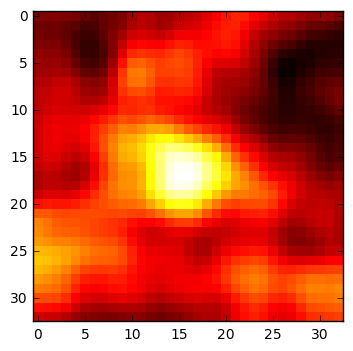

In [13]:
# check the output
print out.shape
print np.mean(out)
print np.max(out)
print np.min(out)
plt.imshow(out[2], interpolation='none', cmap='hot')